# GA 1.2: Analysis Notebook

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 1.2, Friday, Sep 13, 2024.*

_This assignment does not need to be turned in._

## Let's account for the latest news!

Imagine that it is April 5, 2025: the **last day** to make a bet for the 2025 Breakup! Our team has a method for predicting breakup time already, and the key piece of information that you need to provide is an estimate of **ice thickness.** Of course, we know that there is a lot of variability in the growth and melting of ice due to the weather conditions, so we also need to evaluate the **uncertainty** in our estimate.

In short, your task in this notebook is to provide an estimate of the mean and standard deviation of the ice thickness given uncertain temperature as an input variable.

## The Ice Thickness Model

To model the ice growth, you want to use the classical _Stefan's Problem_, which aims to determine how an ice layer grows as a function of time, given the constraint that the temperature of air ($T_{air}$) is constant, smaller than the freezing temperature $T_{fr}$ and everywhere the same.


![Sketch](./sketch_ice.png)

Using this problem, we can model ice growth as:

$$
H^2_{ice}-H^2_{ice,0} = \frac{2 k_{ice}}{\rho_{ice} l}\int{(T_s-T_{fr})}dt
$$

where $H_{ice}$ is the thickness of the ice at a given time $t$, $H_{ice,0}$ is the thickness of the ice at time $t=0$, $k_{ice}=2.2W/(K \cdot m)$ is the thermal conductivity of ice, $\rho_{ice}=917 kg/m^3$ is the density of ice, $l = 333,4 J/g = 333,4 kJ/kg$ is the latent heat of fusion, $T_s$ is the equal to the temperature of the air and $T_{fr}=273K$ is the freezing temperature of water.

We want to estimate the ice thickness after 3 days, and will assume that the temperature remains stable during that period. Therefore, the previous equation will lead to:

$$
H_{ice} = \sqrt{\frac{2 k_{ice}}{\rho_{ice} l}\Delta T \Delta t+H^2_{ice,0}}
$$

where $\Delta T = |T_s-T_{fr}|$ and $\frac{2 k_{ice}}{\rho_{ice} l} \approx 1.44 \cdot 10^{-8} \ m^2/K s$

**Previous work provides the following data:**
- Based on the samples of ice measurements, the mean thickness is $\mu_{H0}=0.20m$ and the standard deviation of thickness is $\sigma_{H0}=0.03m$.
- Based on the forecast, the mean air temperature during the next 3 days is $\mu_T=263K$ and the standard deviation of the temperature of $\sigma_T=4K$.
- The rest of the variables are deterministic.
- The ice thickness and the predicted temperature are independent random variables.

**The goal of this notebook is to carry out the uncertainty propagation and validation of the propagation model. Then you will use the results to answer a few questions in the `Report.md` file.**

*Note that you are interested in the increment of temperature $|T_s-T_{fr}|$, whose mean is $\mu_{iT}=|263-273|=10K$ and $\sigma_{iT}=4K$.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import probplot

plt.rcParams.update({'font.size': 14})

#### Internal equation check

In [2]:
def stefan(constant, H0, Ts, Tfr, time):
    return np.sqrt(constant*time*abs(Ts-Tfr) + H0**2)

In [3]:
stefan(1.44*10**(-8), 0.15, 261, 273, 3*24*3600)

0.2594026985210447

## Part 1: Write all necessary functions

1. Apply the propagation laws with `H_taylor()` to find the mean and standard deviation of the linearized function of random variables 
2. Find the distribution of `H_ice` numerically with a simulation, then compare this to the Normal distribution defined by the mean and standard deviation of the linearized function of random variables


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1:</b>   
Complete the two functions in the cell below, and support your work by including an image showing the analytic equations.
</p>
</div>

In [4]:
def H_taylor(mu_H0, mu_iT, sigma_H0, sigma_iT):
    """ Taylor series approximation of mean and std of h """
    
    constant = 1.44*10**(-8)
    time = 3*24*3600
    
    dhdiT = ((constant*time*mu_iT + mu_H0**2)**(-0.5))*constant/2*time
    dhdH0 = ((constant*time*mu_iT + mu_H0**2)**(-0.5))*mu_H0
    
    dhdiT_2 = -((constant/2*time)**2)*(constant*time*mu_iT+mu_H0**2)**(-1.5)
    dhdH0_2 = (((constant*time*mu_iT + mu_H0**2)**(-0.5)) - 
              mu_H0**2*(constant*time*mu_iT + mu_H0**2)**(-1.5))
    
    mu_H_0 = np.sqrt(constant*time*mu_iT + mu_H0**2)
    mu_H = mu_H_0 + 0.5*dhdiT_2*sigma_iT**2 + 0.5*dhdH0_2*sigma_H0**2
    var_H = (dhdiT**2)*sigma_iT**2 + (dhdH0**2)*sigma_H0**2
    sigma_H = np.sqrt(var_H)
    
    return mu_H, sigma_H

def samples_plot(N, mu_H0, mu_iT, sigma_H0, sigma_iT):
    """Generate samples and plots for V
    
    Compares the approximated Normal distribution of V to numerically
    approximated distribution, found by sampling from the input
    distributions.
    
    Return: a plot and the mean and std dev of simulated values of H_ice.
    """
    constant = 1.44*10**(-8)
    time = 3*24*3600
    
    H0_samples = np.random.normal(mu_H0, sigma_H0, N)
    iT_samples = np.random.normal(mu_iT, sigma_iT, N)
    h_samples = np.sqrt(constant*time*iT_samples + H0_samples**2)
    mu_H = np.mean(h_samples)
    sigma_H = np.std(h_samples)
    
    # Plot histogram
    xmin = np.min(h_samples)
    xmax = np.max(h_samples)
    x = np.linspace(xmin, xmax, 100)
    fig, ax = plt.subplots(1, 2, figsize = (16, 6))
    ax[0].hist(h_samples, bins = 40, density = True, edgecolor='black', linewidth=1.2, 
               label = 'Empirical PDF of ${H_{ice}}$')
    
    # Add normal pdf in same figure
    ax[0].plot(x, norm.pdf(x, mu_H, sigma_H), color = 'black',
               lw = 2.5, label='Normal PDF')
    ax[0].set_xlim(xmin, xmax)
    ax[0].legend()
    ax[0].set_xlabel('${H_{ice} [m]}$')
    ax[0].set_ylabel('Density')
    ax[0].set_title(f'Simulation with {N} simulated realizations'
                    + '\n' + f'mean = {mu_H:.3e}' 
                    f'm and std = {sigma_H:.3e} m')
    
    # Add probability plot in right-side panel
    probplot(h_samples, dist = norm, fit = True, plot = ax[1])
    ax[1].legend(['Generated samples', 'Normal fit'])
    ax[1].get_lines()[1].set_linewidth(2.5)
    plt.show()
    
    return mu_H, sigma_H

## Part 2: Uncertainty Propagation

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2: Analysis</b><br>
Use the functions defined in Task 1 to compute the mean and standard deviation of the linearized function of random variables, and compare the distribution defined by this result to the distribution of $H_{ice}$ found using simulation.
</p>
</div>

Now we can compute the $\mu_H$ and $\sigma_H$ as a function of:
- $\mu_{iT}=10K$ and $\sigma_{iT}=4K$
- $\mu_{H0}=0.20m$ and $\sigma_{H0}=0.03m$

Comparison of propagated and simulated distributions:




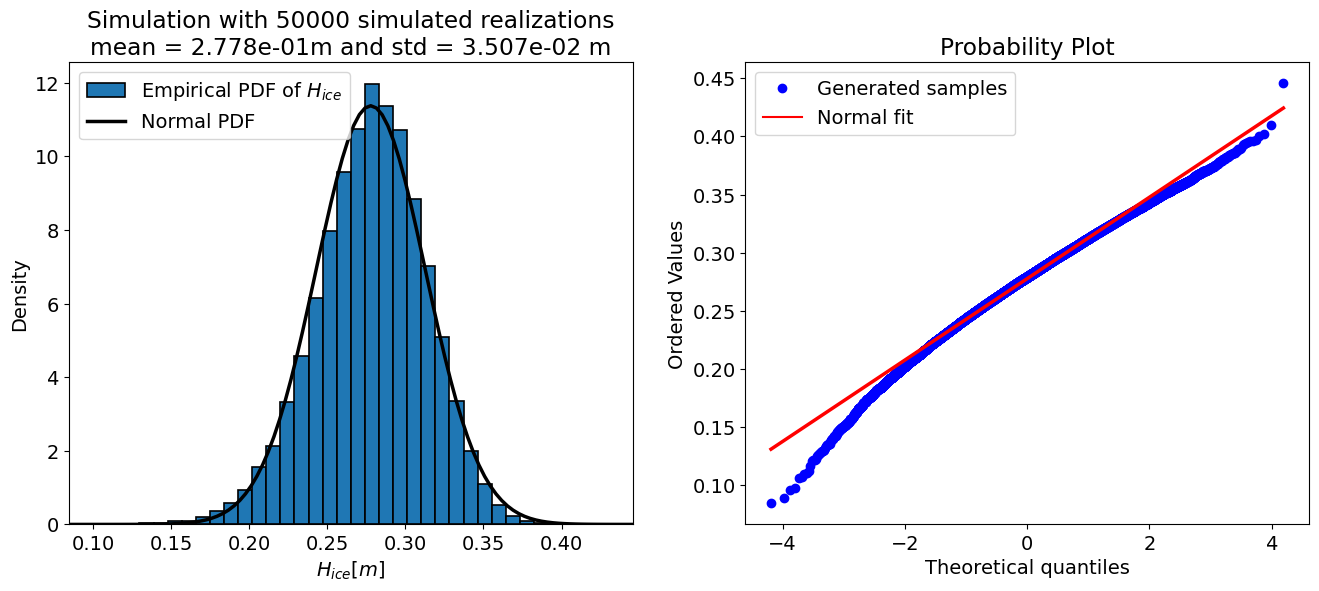



Mean and standard deviation of linearized function:
  μ ₕ= 0.278 m
  σ ₕ= 0.034 m


Mean and standard deviation of simulated distribution:
  μ ₕ = 0.278 m
  σ ₕ= 0.035 m




In [5]:
mu_iT = 10
sigma_iT = 4
mu_H0 = 0.20
sigma_H0 = 0.03
N = 50000

mu_H, sigma_H = H_taylor(mu_H0, mu_iT, sigma_H0, sigma_iT)

print('Comparison of propagated and simulated distributions:\n\n')
mu_H_simulated, sigma_H_simulated = samples_plot(N, mu_H0, mu_iT, sigma_H0, sigma_iT)

print('\n\nMean and standard deviation of linearized function:')
print('  \N{GREEK SMALL LETTER MU}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H}=',
      f'{mu_H:.3f}', 'm')
print('  \N{GREEK SMALL LETTER SIGMA}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H}=',
      f'{sigma_H:.3f}', 'm')

print('\n\nMean and standard deviation of simulated distribution:')
print('  \N{GREEK SMALL LETTER MU}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H} =',
      f'{mu_H_simulated:.3f}', 'm')
print('  \N{GREEK SMALL LETTER SIGMA}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H}=',
      f'{sigma_H_simulated:.3f}', 'm')
print('\n')

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3: Validation</b><br>
The code cell below can be used for your answer to one of the questions in the Report, where you are asked to consider the "inaccurate" values that might be produced by this model. 
</p>
</div>

In [ ]:
# YOUR_CODE_HERE

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>Once you have completed the analysis in this notebook, proceed to the questions in <code>Report.md</code></p></div>

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" />
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" />
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2024 <a rel="MUDE" href="http://mude.citg.tudelft.nl/">MUDE</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">CC BY 4.0 License</a>.